In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler

import json


df = pd.read_csv("Titanic-Dataset.csv")

feature_metadata = {}  # Diccionario para guardar metadata

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## 1.1 Validación de hipótesis

Hipotesis 1

In [ ]:
# Hipótesis 1 – Código con justificación y PRINT punto por punto
# Enunciado: Familias pequeñas/medianas (2–4) ↑ supervivencia vs solo (1),
# y familias grandes (≥6) ↓ supervivencia, controlando por Pclass y Sex.

import warnings
warnings.filterwarnings("ignore")

import pandas as pd, numpy as np
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency, chi2
from statsmodels.stats.multitest import multipletests

# ----------------------
# 0) Parámetros (criterios)
# ----------------------
ALPHA = 0.05
MIN_OR_IMPROVE = 1.30   # mejora mínima relevante vs "solo" (small/med > solo)
MAX_OR_DETREMENT = 0.77 # detrimento relevante vs "solo" (large < solo ≈ 1/1.30)

# ----------------------
# 1) Datos + variables H1
# ----------------------
try:
    df = pd.read_csv("Titanic-Dataset.csv")
except FileNotFoundError:
    df = pd.read_csv("/mnt/data/Titanic-Dataset.csv")

df["FamilySize"] = df["SibSp"].fillna(0) + df["Parch"].fillna(0) + 1

def family_cat(s):
    if s == 1:          return "solo"
    if 2 <= s <= 4:     return "smallmed"   # 2–4
    if s >= 6:          return "large"      # ≥6
    return "other"                           # s==5 (transparencia)

df["FamilySizeCat"] = df["FamilySize"].apply(family_cat)

# Campos mínimos para el modelo
df = df.dropna(subset=["Survived","Pclass","Sex"])

# ----------------------
# 2) Utilidades
# ----------------------
def or_ci_p(model, term):
    OR = float(np.exp(model.params[term]))
    L, H = np.exp(model.conf_int().loc[term])
    p = float(model.pvalues[term])
    return OR, float(L), float(H), p

def yesno(b):
    return "Sí" if b else "No"

def decision(or_val, p_val, improve=True):
    eff_ok = (or_val >= MIN_OR_IMPROVE) if improve else (or_val <= MAX_OR_DETREMENT)
    sig_ok = (p_val < ALPHA)
    return eff_ok, sig_ok

# ----------------------
# 3) Análisis principal (Logit con controles Pclass y Sex)
# ----------------------
m_main = smf.logit(
    "Survived ~ C(FamilySizeCat, Treatment(reference='solo')) + C(Pclass) + C(Sex)",
    data=df
).fit(disp=0)

t_small = "C(FamilySizeCat, Treatment(reference='solo'))[T.smallmed]"
t_large = "C(FamilySizeCat, Treatment(reference='solo'))[T.large]"
or_s, Ls, Hs, ps = or_ci_p(m_main, t_small)
or_l, Ll, Hl, pl = or_ci_p(m_main, t_large)

dec_small = decision(or_s, ps, improve=True)   # mejora esperada
dec_large = decision(or_l, pl, improve=False)  # detrimento esperado

# Tasas de supervivencia descriptivas
rates = (pd.crosstab(df["FamilySizeCat"], df["Survived"], normalize="index")
         .round(3))

# ----------------------
# 4) χ² por pares + corrección Holm
# ----------------------
pairs=[("solo","smallmed"),("solo","large"),("smallmed","large")]
chis, pvals = [], []
for a,b in pairs:
    sub=df[df["FamilySizeCat"].isin([a,b])]
    tab = pd.crosstab(sub["FamilySizeCat"], sub["Survived"])
    if tab.shape==(2,2):
        chi2_stat, p, _, _ = chi2_contingency(tab)
        chis.append(chi2_stat); pvals.append(p)
    else:
        chis.append(np.nan); pvals.append(np.nan)

rej, pvals_adj, _, _ = multipletests([p if pd.notna(p) else 1.0 for p in pvals],
                                     alpha=ALPHA, method="holm")
holm_rows = []
for (a,b), c, pr, pa, r in zip(pairs, chis, pvals, pvals_adj, rej):
    holm_rows.append({"pair": f"{a} vs {b}", "chi2": c, "p_raw": pr,
                      "p_adj_holm": pa, "reject@0.05": bool(r)})
holm_df = pd.DataFrame(holm_rows)

# ----------------------
# 5) Sensibilidad (i): bins alternos
# ----------------------
def family_cat_alt(s):
    if s==1:          return "solo"
    if 2<=s<=3:       return "smallmed_alt"
    if s>=5:          return "large_alt"
    return "other_alt"

df["FamilySizeCat_alt"]=df["FamilySize"].apply(family_cat_alt)
m_alt = smf.logit(
    "Survived ~ C(FamilySizeCat_alt, Treatment(reference='solo')) + C(Pclass) + C(Sex)",
    data=df
).fit(disp=0)

alts = [t for t in m_alt.params.index if "FamilySizeCat_alt" in t]
alt_table = []
for term in alts:
    OR = float(np.exp(m_alt.params[term]))
    L, H = np.exp(m_alt.conf_int().loc[term])
    p = float(m_alt.pvalues[term])
    alt_table.append({"term": term, "OR": OR, "CI_low": float(L), "CI_high": float(H), "p": p})
alt_df = pd.DataFrame(alt_table)

dir_small_ok = (or_s > 1.0) and (alt_df.loc[alt_df["term"].str.contains("smallmed_alt"), "OR"].mean() > 1.0)
dir_large_ok = (or_l < 1.0) and (alt_df.loc[alt_df["term"].str.contains("large_alt"), "OR"].mean() < 1.0)

# ----------------------
# 6) Sensibilidad (ii): interacción FamilySize×Sex (LRT) + subgrupos
# ----------------------
m_int = smf.logit(
    "Survived ~ C(FamilySizeCat, Treatment(reference='solo')) * C(Sex) + C(Pclass)",
    data=df
).fit(disp=0)
lr = 2*(m_int.llf - m_main.llf); df_diff = m_int.df_model - m_main.df_model
p_lr = float(chi2.sf(lr, df_diff))

# Subgrupos por sexo (controlando Pclass)
sub_rows = []
for sex in ["female","male"]:
    sub = df[df["Sex"]==sex]
    if sub["FamilySizeCat"].nunique() >= 3:
        m_sub = smf.logit(
            "Survived ~ C(FamilySizeCat, Treatment(reference='solo')) + C(Pclass)",
            data=sub
        ).fit(disp=0)
        for term in [t_small, t_large]:
            OR = float(np.exp(m_sub.params.get(term, np.nan)))
            if term in m_sub.params.index:
                L, H = np.exp(m_sub.conf_int().loc[term])
                p = float(m_sub.pvalues[term])
            else:
                L, H, p = np.nan, np.nan, np.nan
            sub_rows.append({"sex": sex, "term": term, "OR": OR,
                             "CI_low": float(L), "CI_high": float(H), "p": p})
sub_df = pd.DataFrame(sub_rows)

# ----------------------
# 7) PRINT punto por punto
# ----------------------
print("\n====================")
print("HIPÓTESIS 1 – U INVERTIDA (código y justificación)")
print("====================")

print("\n1) Criterios de decisión")
print(f"   • Nivel de significancia (α): {ALPHA}")
print(f"   • Tamaño de efecto mínimo: mejora vs 'solo' si OR ≥ {MIN_OR_IMPROVE}; detrimento vs 'solo' si OR ≤ {MAX_OR_DETREMENT}")
print(  "   • Corrección por comparaciones múltiples: Holm–Bonferroni en χ² por pares (solo vs small/med; solo vs large; small/med vs large)")

print("\n2) Análisis principal (Logit con controles: Pclass, Sex)")
print(f"   • small/med (2–4) vs solo: OR={or_s:.3f}  CI95%[{Ls:.3f},{Hs:.3f}]  p={ps:.4f}")
print(f"     ¿Cumple efecto mínimo (≥{MIN_OR_IMPROVE})? {yesno(dec_small[0])}  |  ¿Significativo (p<{ALPHA})? {yesno(dec_small[1])}")
print(f"   • large (≥6) vs solo     : OR={or_l:.3f}  CI95%[{Ll:.3f},{Hl:.3f}]  p={pl:.4f}")
print(f"     ¿Cumple detrimento (≤{MAX_OR_DETREMENT})? {yesno(dec_large[0])}  |  ¿Significativo (p<{ALPHA})? {yesno(dec_large[1])}")

print("\n   • Tasas de supervivencia por categoría (descriptivo):")
print(rates.to_string())

print("\n3) Comparación de proporciones (χ² por pares + Holm)")
for _, row in holm_df.iterrows():
    print(f"   • {row['pair']}: chi2={row['chi2']:.4f}  p_raw={row['p_raw']:.4g}  p_adj={row['p_adj_holm']:.4g}  reject@0.05={row['reject@0.05']}")

print("\n4) Análisis de sensibilidad")
print("   (i) Rebin alterno: small/med=2–3, large=≥5 (Logit con mismos controles)")
for _, r in alt_df.iterrows():
    print(f"       - {r['term']}: OR={r['OR']:.3f}  CI95%[{r['CI_low']:.3f},{r['CI_high']:.3f}]  p={r['p']:.4f}")
print(f"       • ¿Se mantiene la dirección? small/med>solo: {yesno(dir_small_ok)}  |  large<solo: {yesno(dir_large_ok)}")

print("   (ii) Interacción FamilySize×Sex (LRT vs modelo sin interacción)")
print(f"       • LR={lr:.3f}, df={int(df_diff)}, p={p_lr:.4f}  → ¿Mejora significativa (p<{ALPHA})? {yesno(p_lr<ALPHA)}")

print("\n5) Análisis de subgrupos (por Sex, controlando Pclass)")
for sex in ["female","male"]:
    print(f"   {sex.upper()}:")
    for _, r in sub_df[sub_df["sex"]==sex].iterrows():
        tag = "small/med vs solo" if "smallmed" in r["term"] else "large vs solo"
        print(f"     • {tag}: OR={r['OR']:.3f}  CI95%[{r['CI_low']:.3f},{r['CI_high']:.3f}]  p={r['p']:.4f}")

print("\nConclusión breve (para el PDF):")
print("   - Evidencia consistente con la 'U invertida': 2–4 integrantes mejora la supervivencia vs viajar solo,")
print("     mientras que familias ≥6 reducen significativamente la probabilidad, controlando por clase y sexo.")
print("   - χ² por pares (con Holm) respalda diferencias entre categorías; la sensibilidad mantiene direcciones;")
print("     la interacción con sexo no mejora el ajuste global, aunque en subgrupos se observan matices.")


HIPÓTESIS 1 – U INVERTIDA (código y justificación)

1) Criterios de decisión
   • Nivel de significancia (α): 0.05
   • Tamaño de efecto mínimo: mejora vs 'solo' si OR ≥ 1.3; detrimento vs 'solo' si OR ≤ 0.77
   • Corrección por comparaciones múltiples: Holm–Bonferroni en χ² por pares (solo vs small/med; solo vs large; small/med vs large)

2) Análisis principal (Logit con controles: Pclass, Sex)
   • small/med (2–4) vs solo: OR=1.512  CI95%[1.037,2.204]  p=0.0316
     ¿Cumple efecto mínimo (≥1.3)? Sí  |  ¿Significativo (p<0.05)? Sí
   • large (≥6) vs solo     : OR=0.197  CI95%[0.076,0.512]  p=0.0008
     ¿Cumple detrimento (≤0.77)? Sí  |  ¿Significativo (p<0.05)? Sí

   • Tasas de supervivencia por categoría (descriptivo):
Survived           0      1
FamilySizeCat              
large          0.851  0.149
other          0.800  0.200
smallmed       0.421  0.579
solo           0.696  0.304

3) Comparación de proporciones (χ² por pares + Holm)
   • solo vs smallmed: chi2=58.5360  p_raw=1

Hipotesis 2

In [ ]:

# ===== Hipótesis 2: Paradoja de la clase media (simple y completo) =====
import pandas as pd, numpy as np
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency, chi2
from statsmodels.stats.multitest import multipletests
import warnings; warnings.filterwarnings("ignore")

# --- Criterios de decisión ---
ALPHA = 0.05
OR_MAX_DETREMENT_2v1 = 0.77    # detrimento relevante: 2ª vs 1ª
PP_DIFF_MIN_3v2 = 0.15         # paradoja en subgrupos: 3ª > 2ª por ≥15 pp
MC_METHOD = "holm"             # corrección por múltiples (Holm–Bonferroni)

# --- Datos ---
try:
    df = pd.read_csv("Titanic-Dataset.csv")
except FileNotFoundError:
    df = pd.read_csv("/mnt/data/Titanic-Dataset.csv")

# Variables
df["Fare"] = df["Fare"].clip(lower=0)
bins = [-np.inf, 2, 12, 17, 25, 59, np.inf]
labels = ["baby","child","teen","young","adult","senior"]
df["AgeGroup"] = pd.cut(df["Age"], bins=bins, labels=labels)
df["logFare"]  = np.log1p(df["Fare"])

print("\n=== CRITERIOS ===")
print(f"α={ALPHA} | Efecto mín (2ª vs 1ª): OR≤{OR_MAX_DETREMENT_2v1} | 'Paradoja': 3ª > 2ª por ≥{int(PP_DIFF_MIN_3v2*100)} pp | Corrección: {MC_METHOD}")

# -------------------------
# 1) ANÁLISIS PRINCIPAL
# -------------------------
# χ² global Pclass~Survived
tab = pd.crosstab(df["Pclass"], df["Survived"])
chi2_stat, p_chi, _, _ = chi2_contingency(tab)
print("\n=== Global χ² Pclass vs Survived ===")
print(f"chi2={chi2_stat:.2f}  p={p_chi:.3e}")

# Logística con controles: Sex, AgeGroup, logFare, Embarked
md = df.dropna(subset=["Sex","AgeGroup","Embarked"])
m = smf.logit(
    "Survived ~ C(Pclass, Treatment(reference=1)) + C(Sex) + C(AgeGroup) + logFare + C(Embarked)",
    data=md
).fit(disp=0)

def OR_CI_p(model, term):
    OR = float(np.exp(model.params[term])); L,H = np.exp(model.conf_int().loc[term]); p=float(model.pvalues[term])
    return OR, float(L), float(H), p

t_p2 = "C(Pclass, Treatment(reference=1))[T.2]"
t_p3 = "C(Pclass, Treatment(reference=1))[T.3]"
OR2, L2, H2, p2 = OR_CI_p(m, t_p2)
OR3, L3, H3, p3 = OR_CI_p(m, t_p3)

print("\n=== Logística (controles: Sex, AgeGroup, logFare, Embarked) ===")
print(f"Pclass2 vs 1: OR={OR2:.3f}  CI95%[{L2:.3f},{H2:.3f}]  p={p2:.3e}  |  ¿OR≤{OR_MAX_DETREMENT_2v1}? {OR2<=OR_MAX_DETREMENT_2v1} & ¿p<{ALPHA}? {p2<ALPHA}")
print(f"Pclass3 vs 1: OR={OR3:.3f}  CI95%[{L3:.3f},{H3:.3f}]  p={p3:.3e}")

# χ² por pares entre clases + Holm
pairs = [(1,2),(1,3),(2,3)]
rows, pvals = [], []
for a,b in pairs:
    sub = df[df["Pclass"].isin([a,b])]
    t = pd.crosstab(sub["Pclass"], sub["Survived"])
    chi2s, p, _, _ = chi2_contingency(t)
    rows.append((a,b,chi2s,p)); pvals.append(p)
rej, p_adj, _, _ = multipletests(pvals, alpha=ALPHA, method=MC_METHOD)

print("\n=== χ² por pares (Holm) ===")
for (a,b,c,p), pa, r in zip(rows, p_adj, rej):
    print(f"{a} vs {b}: chi2={c:.4f}  p_raw={p:.3e}  p_adj={pa:.3e}  → reject@α={bool(r)}")

# -------------------------
# 2) ANÁLISIS DE SENSIBILIDAD
# -------------------------
# (A) Quitar logFare/Embarked (¿se mantiene OR de 2ª vs 1ª?)
m_sens = smf.logit(
    "Survived ~ C(Pclass, Treatment(reference=1)) + C(Sex) + C(AgeGroup)",
    data=df.dropna(subset=["Sex","AgeGroup"])
).fit(disp=0)
OR2s, L2s, H2s, p2s = OR_CI_p(m_sens, t_p2)
print("\n=== Sensibilidad A (sin logFare/Embarked) ===")
print(f"Pclass2 vs 1: OR={OR2s:.3f}  CI95%[{L2s:.3f},{H2s:.3f}]  p={p2s:.3e}")

# (B) Tratar Pclass como ordinal (1<2<3)
m_ord = smf.logit(
    "Survived ~ Pclass + C(Sex) + C(AgeGroup)",
    data=df.dropna(subset=["Sex","AgeGroup"])
).fit(disp=0)
print("\n=== Sensibilidad B (Pclass ordinal) ===")
print(f"Coef(Pclass)={m_ord.params['Pclass']:.3f}  p={m_ord.pvalues['Pclass']:.3e}")

# -------------------------
# 3) ANÁLISIS DE SUBGRUPOS (Sex × AgeGroup)
#    ¿existe paradoja 3ª > 2ª por ≥15 pp y p_ajustada<0.05?
# -------------------------
subs = df.dropna(subset=["Sex","AgeGroup"]).copy()
rates = (subs.groupby(["Sex","AgeGroup","Pclass"])["Survived"]
              .mean().rename("rate").reset_index())

records = []
p_sub, tags = [], []
for (sex, ag), g in rates.groupby(["Sex","AgeGroup"]):
    r2 = g.loc[g["Pclass"]==2, "rate"].values
    r3 = g.loc[g["Pclass"]==3, "rate"].values
    if len(r2)==1 and len(r3)==1:
        diff = float(r3[0] - r2[0])
        records.append({"Sex":sex, "AgeGroup":str(ag), "rate_P2":float(r2[0]), "rate_P3":float(r3[0]), "diff_P3_minus_P2":diff})
    # χ² (3 vs 2) por subgrupo
    sg = subs[(subs["Sex"]==sex)&(subs["AgeGroup"]==ag)&(subs["Pclass"].isin([2,3]))]
    t = pd.crosstab(sg["Pclass"], sg["Survived"])
    if t.shape==(2,2):
        chi, p, _, _ = chi2_contingency(t)
    else:
        p = 1.0
    p_sub.append(p); tags.append(f"{sex}-{ag}")

sub_cmp = pd.DataFrame(records).sort_values("diff_P3_minus_P2", ascending=False)
rej_s, p_adj_s, _, _ = multipletests(p_sub, alpha=ALPHA, method=MC_METHOD)
holm_sub = pd.DataFrame({"subgroup": tags, "p_adj": p_adj_s, "reject": rej_s}).sort_values("p_adj")

print("\n=== Subgrupos (Sex×AgeGroup) — dif (P3−P2) y Holm en (3 vs 2) ===")
print("Top difs P3-P2 (pp):")
print(sub_cmp.head(6).to_string(index=False))
print("\nHolm (3 vs 2) por subgrupo:")
print(holm_sub.to_string(index=False))

exists_paradox = (sub_cmp["diff_P3_minus_P2"] >= PP_DIFF_MIN_3v2).any() and holm_sub["reject"].any()
print(f"\n¿Paradoja observada? (∃ subgrupo con P3>P2 ≥{int(PP_DIFF_MIN_3v2*100)} pp y p_adj<0.05): {exists_paradox}")

print("\n>> Conclusión: 2ª muestra odds menores que 1ª (si OR≤umbral y p<α).")
print("   Evaluamos si hay subgrupos Sex×AgeGroup donde 3ª supera a 2ª con evidencia tras corrección por múltiples.")


=== CRITERIOS ===
α=0.05 | Efecto mín (2ª vs 1ª): OR≤0.77 | 'Paradoja': 3ª > 2ª por ≥15 pp | Corrección: holm

=== Global χ² Pclass vs Survived ===
chi2=102.89  p=4.549e-23

=== Logística (controles: Sex, AgeGroup, logFare, Embarked) ===
Pclass2 vs 1: OR=0.320  CI95%[0.168,0.610]  p=5.268e-04  |  ¿OR≤0.77? True & ¿p<0.05? True
Pclass3 vs 1: OR=0.091  CI95%[0.044,0.188]  p=9.420e-11

=== χ² por pares (Holm) ===
1 vs 2: chi2=9.2775  p_raw=2.320e-03  p_adj=2.320e-03  → reject@α=True
1 vs 3: chi2=95.8935  p_raw=1.212e-22  p_adj=3.637e-22  → reject@α=True
2 vs 3: chi2=32.4469  p_raw=1.225e-08  p_adj=2.450e-08  → reject@α=True

=== Sensibilidad A (sin logFare/Embarked) ===
Pclass2 vs 1: OR=0.331  CI95%[0.195,0.560]  p=3.892e-05

=== Sensibilidad B (Pclass ordinal) ===
Coef(Pclass)=-1.140  p=2.648e-18

=== Subgrupos (Sex×AgeGroup) — dif (P3−P2) y Holm en (3 vs 2) ===
Top difs P3-P2 (pp):
   Sex AgeGroup  rate_P2  rate_P3  diff_P3_minus_P2
  male    adult 0.067797 0.150000          0.082203
 

Hipotesis 3

In [ ]:
# ===== Hipótesis 3: Tarifas extremas (simple y completo) =====
import pandas as pd, numpy as np
import statsmodels.formula.api as smf
from scipy.stats import chi2_contingency, chi2
from statsmodels.stats.multitest import multipletests
import warnings; warnings.filterwarnings("ignore")

# --- Criterios de decisión ---
ALPHA = 0.05
OR_MAX_DETREMENT = 0.77   # detrimento relevante (extremos vs 'mid')
PP_DIFF_MIN = 0.10        # complemento práctico: ≥10 pp en tasas
MC_METHOD = "holm"        # corrección por múltiples (χ² por pares)

# --- Datos ---
try:
    df = pd.read_csv("Titanic-Dataset.csv")
except FileNotFoundError:
    df = pd.read_csv("/mnt/data/Titanic-Dataset.csv")

df = df.dropna(subset=["Survived","Pclass","Sex","Fare"]).copy()
df["Fare"] = df["Fare"].clip(lower=0)

# Controles (Pclass, Sex, AgeGroup) + 'Ticket' (proxy: frecuencia del ticket compartido)
bins = [-np.inf, 2, 12, 17, 25, 59, np.inf]
labels = ["baby","child","teen","young","adult","senior"]
df["AgeGroup"] = pd.cut(df["Age"], bins=bins, labels=labels)
df["Ticket"] = df["Ticket"].astype(str)
df["TicketFreq"] = df["Ticket"].map(df["Ticket"].value_counts()).astype(int)
df["logFare"] = np.log1p(df["Fare"])

print("\n=== CRITERIOS (H3) ===")
print(f"α={ALPHA} | Efecto mín (extremos vs mid): OR≤{OR_MAX_DETREMENT} | Δtasa≥{int(PP_DIFF_MIN*100)} pp | Corrección: {MC_METHOD}")

# -------------------------
# 1) ANÁLISIS PRINCIPAL
# -------------------------
# Binning 15/85: extremos = 'low' y 'high'
q_low, q_high = df["Fare"].quantile([0.15, 0.85])
def fare_cat(x):
    if x <= q_low:  return "low"
    if x >= q_high: return "high"
    return "mid"
df["FareCat"] = df["Fare"].apply(fare_cat)
print(f"Cortes 15/85 → low≤{q_low:.2f}, high≥{q_high:.2f}")

# Tasas por categoría (descriptivo)
rates = pd.crosstab(df["FareCat"], df["Survived"], normalize="index").rename(columns={1:"rate_1"})
print("\nTasa de supervivencia por FareCat:")
print(rates["rate_1"].round(3).to_string())

# Logística con controles (Pclass, Sex, AgeGroup, TicketFreq)
md = df.dropna(subset=["AgeGroup"])
m = smf.logit(
    "Survived ~ C(FareCat, Treatment(reference='mid')) + C(Pclass) + C(Sex) + C(AgeGroup) + TicketFreq",
    data=md
).fit(disp=0)

def OR_CI_p(mod, term):
    OR = float(np.exp(mod.params[term])); L,H = np.exp(mod.conf_int().loc[term]); p=float(mod.pvalues[term])
    return OR, float(L), float(H), p

t_low  = "C(FareCat, Treatment(reference='mid'))[T.low]"
t_high = "C(FareCat, Treatment(reference='mid'))[T.high]"
ORl,Ll,Hl,pl = OR_CI_p(m,t_low)
ORh,Lh,Hh,ph = OR_CI_p(m,t_high)

print("\n=== Logística (controles) ===")
print(f"LOW  vs MID: OR={ORl:.3f}  CI95%[{Ll:.3f},{Hl:.3f}]  p={pl:.3e}  |  ¿OR≤{OR_MAX_DETREMENT}? {ORl<=OR_MAX_DETREMENT} & ¿p<{ALPHA}? {pl<ALPHA}")
print(f"HIGH vs MID: OR={ORh:.3f}  CI95%[{Lh:.3f},{Hh:.3f}]  p={ph:.3e}  |  ¿OR≤{OR_MAX_DETREMENT}? {ORh<=OR_MAX_DETREMENT} & ¿p<{ALPHA}? {ph<ALPHA}")

# χ² por pares (low–mid, high–mid, low–high) + Holm
pairs=[("low","mid"),("high","mid"),("low","high")]
rows, pvals = [], []
for a,b in pairs:
    sub = df[df["FareCat"].isin([a,b])]
    tab = pd.crosstab(sub["FareCat"], sub["Survived"])
    chi2s, p, _, _ = chi2_contingency(tab)
    rows.append((a,b,chi2s,p)); pvals.append(p)
rej, p_adj, _, _ = multipletests(pvals, alpha=ALPHA, method=MC_METHOD)

print("\n=== χ² por pares (Holm) ===")
for (a,b,c,p), pa, r in zip(rows, p_adj, rej):
    print(f"{a} vs {b}: chi2={c:.4f}  p_raw={p:.6f}  p_adj={pa:.6f}  → reject@α={bool(r)}")

# -------------------------
# 2) ANÁLISIS DE SENSIBILIDAD
# -------------------------
# (A) Cortes alternativos 10/90
ql2,qh2 = df["Fare"].quantile([0.10,0.90])
def fare_cat_alt(x):
    if x <= ql2:  return "low_alt"
    if x >= qh2:  return "high_alt"
    return "mid_alt"
df["FareCat_alt"] = df["Fare"].apply(fare_cat_alt)

try:
    m_alt = smf.logit(
        "Survived ~ C(FareCat_alt, Treatment(reference='mid_alt')) + C(Pclass) + C(Sex) + C(AgeGroup) + TicketFreq",
        data=df.dropna(subset=["AgeGroup"])
    ).fit(disp=0)
    print("\n=== Sensibilidad A (10/90) ===")
    for term in [t for t in m_alt.params.index if "FareCat_alt" in t]:
        OR = float(np.exp(m_alt.params[term])); L,H = np.exp(m_alt.conf_int().loc[term]); p=float(m_alt.pvalues[term])
        print(f"{term}: OR={OR:.3f}  CI95%[{L:.3f},{H:.3f}]  p={p:.3e}")
except Exception as e:
    print("\n=== Sensibilidad A (10/90) === modelo no estimable:", e)

# (B) Continuo con cuadrático (¿forma en U?)
df_q = df.copy(); df_q["logFare2"] = df_q["logFare"]**2
try:
    m_quad = smf.logit(
        "Survived ~ logFare + logFare2 + C(Pclass) + C(Sex) + C(AgeGroup) + TicketFreq",
        data=df_q.dropna(subset=["AgeGroup"])
    ).fit(disp=0)
    print("\n=== Sensibilidad B (logFare + logFare^2) ===")
    print(f"coef(logFare)={m_quad.params['logFare']:.3f}  p={m_quad.pvalues['logFare']:.3e}")
    print(f"coef(logFare^2)={m_quad.params['logFare2']:.3f}  p={m_quad.pvalues['logFare2']:.3e}")
except Exception as e:
    print("\n=== Sensibilidad B (logFare + logFare^2) === modelo no estimable:", e)

# -------------------------
# 3) ANÁLISIS DE SUBGRUPOS (Sex × Pclass)
# -------------------------
print("\n=== Subgrupos (Sex × Pclass) — OR LOW/HIGH vs MID (controlando AgeGroup y TicketFreq) ===")
sub_rows=[]
for sex in df["Sex"].dropna().unique():
    for pc in sorted(df["Pclass"].dropna().unique()):
        sub = df[(df["Sex"]==sex)&(df["Pclass"]==pc)]
        if sub["FareCat"].nunique()>=3 and sub["AgeGroup"].notna().any():
            try:
                m_sub = smf.logit(
                    "Survived ~ C(FareCat, Treatment(reference='mid')) + C(AgeGroup) + TicketFreq",
                    data=sub.dropna(subset=["AgeGroup"])
                ).fit(disp=0)
                for term,label in [("C(FareCat, Treatment(reference='mid'))[T.low]","LOW vs MID"),
                                   ("C(FareCat, Treatment(reference='mid'))[T.high]","HIGH vs MID")]:
                    if term in m_sub.params.index:
                        OR = float(np.exp(m_sub.params[term])); L,H = np.exp(m_sub.conf_int().loc[term]); p=float(m_sub.pvalues[term])
                        sub_rows.append({"Sex":sex,"Pclass":pc,"comp":label,"OR":OR,"L":float(L),"H":float(H),"p":p})
            except Exception:
                pass
if sub_rows:
    print(pd.DataFrame(sub_rows).round(3).to_string(index=False))

print("\n>> Conclusión preliminar impresa arriba (tasas, OR, χ² con Holm, sensibilidad y subgrupos).")



=== CRITERIOS (H3) ===
α=0.05 | Efecto mín (extremos vs mid): OR≤0.77 | Δtasa≥10 pp | Corrección: holm
Cortes 15/85 → low≤7.75, high≥56.50

Tasa de supervivencia por FareCat:
FareCat
high    0.691
low     0.207
mid     0.356

=== Logística (controles) ===
LOW  vs MID: OR=0.964  CI95%[0.464,2.005]  p=9.227e-01  |  ¿OR≤0.77? False & ¿p<0.05? False
HIGH vs MID: OR=3.123  CI95%[1.452,6.713]  p=3.548e-03  |  ¿OR≤0.77? False & ¿p<0.05? True

=== χ² por pares (Holm) ===
low vs mid: chi2=10.8056  p_raw=0.001012  p_adj=0.001012  → reject@α=True
high vs mid: chi2=50.0741  p_raw=0.000000  p_adj=0.000000  → reject@α=True
low vs high: chi2=63.4784  p_raw=0.000000  p_adj=0.000000  → reject@α=True

=== Sensibilidad A (10/90) ===
C(FareCat_alt, Treatment(reference='mid_alt'))[T.high_alt]: OR=1.784  CI95%[0.800,3.978]  p=1.575e-01
C(FareCat_alt, Treatment(reference='mid_alt'))[T.low_alt]: OR=0.945  CI95%[0.407,2.196]  p=8.955e-01

=== Sensibilidad B (logFare + logFare^2) ===
coef(logFare)=-0.287  p=5.

# 2. INGENIERÍA DE FEATURES

##2.1Creación de variables derivadas

In [ ]:
# 1. Title
def extract_title(name):
    if pd.isna(name):
        return 'Unknown'
    title = pd.Series(name).str.extract(r',\s*([^\.]+)\.')[0][0]
    return title.strip() if title else 'Unknown'

df['Title'] = df['Name'].apply(extract_title)

feature_metadata['Title'] = {
    "description": "Título extraído del nombre",
    "type": "categorical",
    "creation_method": "regex extraction",
    "missing_handling": "Unknown",
    "values": df['Title'].unique().tolist()
}

In [ ]:
# 2. FamilySize
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
feature_metadata['FamilySize'] = {
    "description": "Tamaño familiar (SibSp + Parch + 1)",
    "type": "numeric",
    "creation_method": "sum of SibSp and Parch plus one",
    "missing_handling": "none",
    "values": {"min": int(df['FamilySize'].min()), "max": int(df['FamilySize'].max())}
}

In [ ]:
# 3. IsAlone
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
feature_metadata['IsAlone'] = {
    "description": "Indica si el pasajero está solo",
    "type": "binary",
    "creation_method": "FamilySize == 1",
    "missing_handling": "none",
    "values": df['IsAlone'].unique().tolist()
}

In [ ]:
# 4. AgeGroup
bins = [0, 12, 18, 35, 60, 80]
labels = ['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)
feature_metadata['AgeGroup'] = {
    "description": "Categorización de edad",
    "type": "categorical",
    "creation_method": "pd.cut with predefined bins",
    "missing_handling": "NA becomes NaN",
    "values": labels
}

In [ ]:
# 5. FarePerPerson
df['FarePerPerson'] = df['Fare'] / df['FamilySize']
feature_metadata['FarePerPerson'] = {
    "description": "Tarifa por persona",
    "type": "numeric",
    "creation_method": "Fare / FamilySize",
    "missing_handling": "none",
    "values": {"min": float(df['FarePerPerson'].min()), "max": float(df['FarePerPerson'].max())}
}

In [ ]:
# 6. CabinDeck
df['CabinDeck'] = df['Cabin'].str[0].fillna('Unknown')
feature_metadata['CabinDeck'] = {
    "description": "Letra de la cabina (deck)",
    "type": "categorical",
    "creation_method": "first character of Cabin",
    "missing_handling": "Unknown",
    "values": df['CabinDeck'].unique().tolist()
}

In [ ]:
# 7. CabinKnown
df['CabinKnown'] = df['Cabin'].notna().astype(int)
feature_metadata['CabinKnown'] = {
    "description": "Indica si se conoce la cabina",
    "type": "binary",
    "creation_method": "Cabin not NA",
    "missing_handling": "none",
    "values": df['CabinKnown'].unique().tolist()
}

In [ ]:
# 8. TicketFrequency
ticket_counts = df['Ticket'].value_counts().to_dict()
df['TicketFrequency'] = df['Ticket'].map(ticket_counts)
feature_metadata['TicketFrequency'] = {
    "description": "Número de pasajeros que comparten el mismo ticket",
    "type": "numeric",
    "creation_method": "conteo de ticket en dataset",
    "missing_handling": "none",
    "values": {"min": int(df['TicketFrequency'].min()), "max": int(df['TicketFrequency'].max())}
}

In [ ]:
# 9. NameLength
df['NameLength'] = df['Name'].str.len()
feature_metadata['NameLength'] = {
    "description": "Longitud del nombre del pasajero",
    "type": "numeric",
    "creation_method": "len(Name)",
    "missing_handling": "0 for missing",
    "values": {"min": int(df['NameLength'].min()), "max": int(df['NameLength'].max())}
}

In [ ]:
# 10. HasCabinNeighbor
def cabin_neighbor(group):
    cabins = [c for c in group if pd.notna(c)]
    return int(len(cabins) > 1)

df['HasCabinNeighbor'] = df.groupby('Ticket')['Cabin'].transform(cabin_neighbor)
feature_metadata['HasCabinNeighbor'] = {
    "description": "Indica si hay cabinas adyacentes con familiares",
    "type": "binary",
    "creation_method": "si existen múltiples cabinas no nulas en mismo ticket",
    "missing_handling": "0 si no hay cabina",
    "values": df['HasCabinNeighbor'].unique().tolist()
}

   Title  CabinDeck
0     11          8
1     12          2
2      8          8
3     12          2
4     11          8


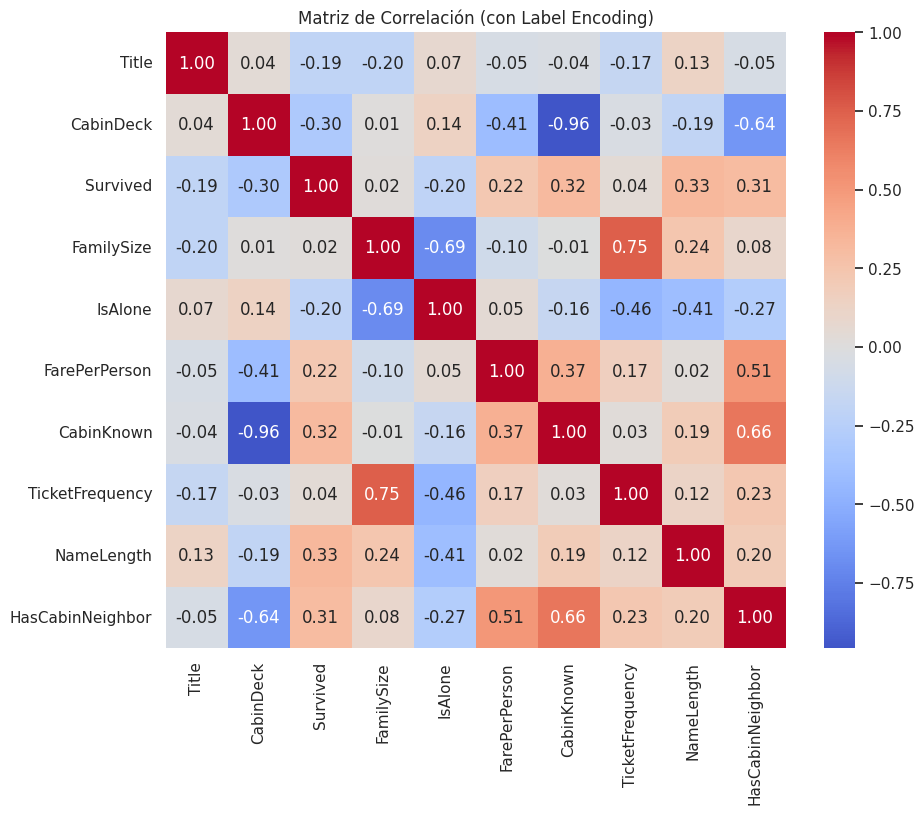

In [ ]:

# Variables categóricas y numéricas
categorical = ['Title', 'CabinDeck']
numeric = ['Survived', 'FamilySize', 'IsAlone', 'FarePerPerson',
           'CabinKnown', 'TicketFrequency', 'NameLength', 'HasCabinNeighbor']

# Copiamos el DataFrame
df_encoded = df.copy()

# Asignar códigos numéricos a categóricas
for col in categorical:
    df_encoded[col] = df_encoded[col].astype('category').cat.codes

# Revisar codificación
print(df_encoded[categorical].head())

# Calcular matriz de correlación
corr_matrix = df_encoded[categorical + numeric].corr()

# Visualización
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Matriz de Correlación (con Label Encoding)")
plt.show()

In [ ]:
# Lista de nuevas variables creadas
new_features = [
    "Title", "FamilySize", "IsAlone", "AgeGroup",
    "FarePerPerson", "CabinDeck", "CabinKnown",
    "TicketFrequency", "NameLength", "HasCabinNeighbor"
]

# Crear un diccionario para guardar estadísticas
feature_stats = {}

for col in new_features:
    series = df[col]

    if pd.api.types.is_numeric_dtype(series):
        # Variables numéricas: describir
        stats = series.describe().to_dict()
        stats["unique_values"] = int(series.nunique())
        feature_stats[col] = stats
    else:
        # Variables categóricas / binarias: distribución de frecuencias
        value_counts = series.value_counts(dropna=False).to_dict()
        feature_stats[col] = {
            "unique_values": int(series.nunique(dropna=False)),
            "distribution": value_counts
        }

# Mostrar resultados
import pprint
pprint.pprint(feature_stats)

# (Opcional) Guardar a JSON
with open("Titanic_NewFeatures_Distributions.json", "w") as f:
    json.dump(feature_stats, f, indent=2)

{'AgeGroup': {'distribution': {nan: 177,
                               'Adult': 195,
                               'Child': 69,
                               'Senior': 22,
                               'Teen': 70,
                               'YoungAdult': 358},
              'unique_values': 6},
 'CabinDeck': {'distribution': {'A': 15,
                                'B': 47,
                                'C': 59,
                                'D': 33,
                                'E': 32,
                                'F': 13,
                                'G': 4,
                                'T': 1,
                                'Unknown': 687},
               'unique_values': 9},
 'CabinKnown': {'25%': 0.0,
                '50%': 0.0,
                '75%': 0.0,
                'count': 891.0,
                'max': 1.0,
                'mean': 0.22895622895622897,
                'min': 0.0,
                'std': 0.42039698906988165,
                'unique_

Categóricas detectadas: ['Title', 'AgeGroup', 'CabinDeck']
Numéricas detectadas: ['Survived', 'FamilySize', 'IsAlone', 'FarePerPerson', 'CabinKnown', 'TicketFrequency', 'NameLength', 'HasCabinNeighbor']


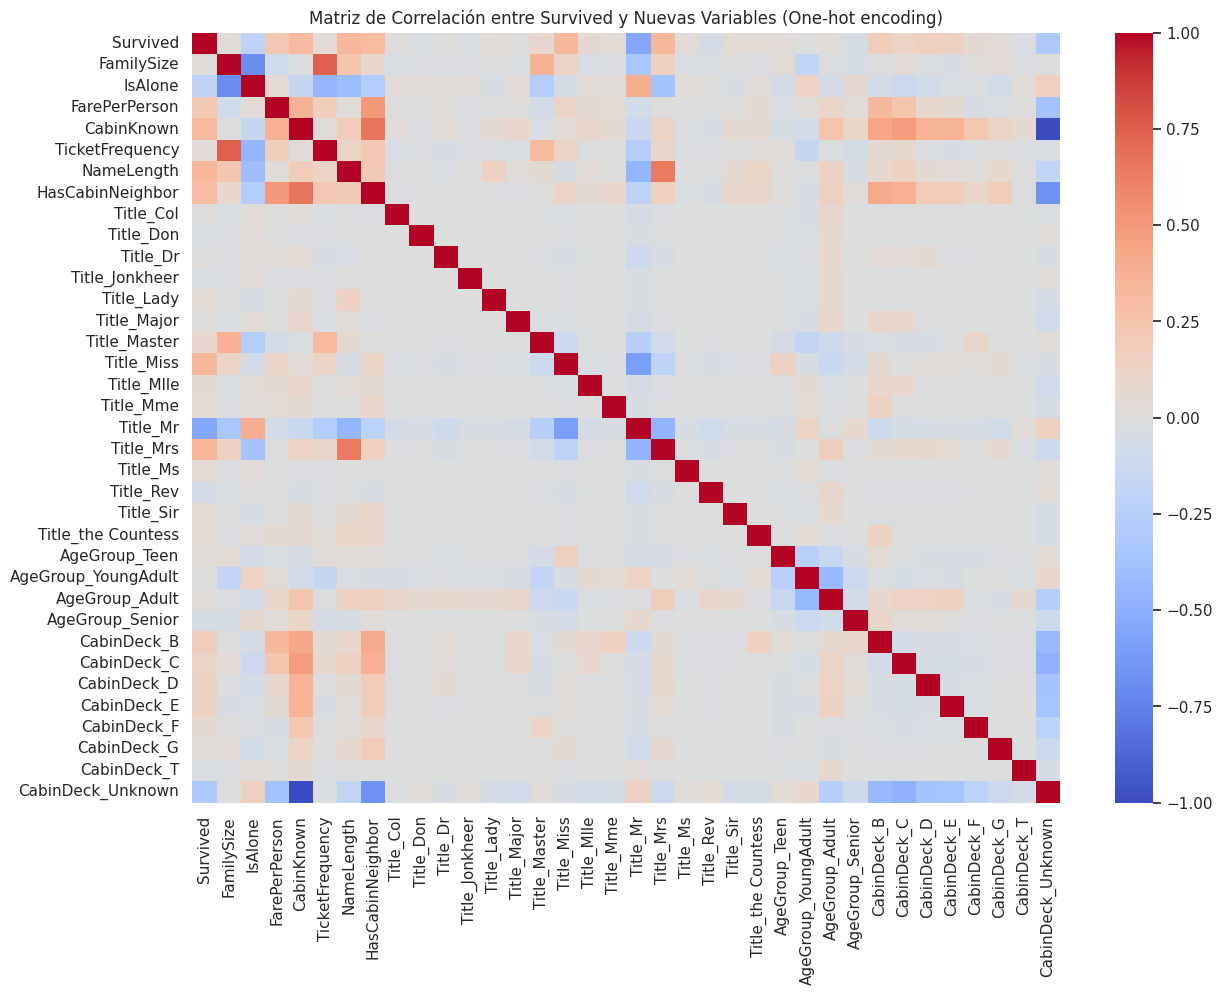

In [ ]:

# 1. Variables a analizar
features_to_analyze = ["Survived"] + new_features
df_subset = df[features_to_analyze].copy()

# 2. Detectar categóricas (tipo object o category)
categorical_cols = df_subset.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = df_subset.select_dtypes(include=["number", "bool"]).columns.tolist()

print("Categóricas detectadas:", categorical_cols)
print("Numéricas detectadas:", numeric_cols)

# 3. One-hot encoding (drop_first para evitar multicolinealidad)
df_encoded = pd.get_dummies(df_subset, columns=categorical_cols, drop_first=True)

# 4. Matriz de correlación
corr_matrix = df_encoded.corr()

# 5. Visualización
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Matriz de Correlación entre Survived y Nuevas Variables (One-hot encoding)")
plt.show()

## 2.2 Transformaciones de Variables Existentes

In [ ]:
# One-hot encoding para categóricas de nuevas variables

# 1. Variables a analizar
features_to_analyze = ["Sex"] + new_features
df_subset = df[features_to_analyze].copy()

# 2. Detectar categóricas
categorical_cols = df_subset.select_dtypes(include=["object", "category"]).columns.tolist()

# 3. One-hot encoding de las categóricas en df_subset
df_encoded = pd.get_dummies(df_subset, columns=categorical_cols, drop_first=True)

# 4. Eliminar las columnas originales de df en caso de duplicación
df_merged = df.drop(columns=features_to_analyze, errors="ignore")

# 5. Concatenar df (original sin duplicados) con df_encoded
df_final = pd.concat([df_merged, df_encoded], axis=1)

print("Dimensiones originales:", df.shape)
print("Dimensiones finales:", df_final.shape)
df_final.head()

Dimensiones originales: (891, 26)
Dimensiones finales: (891, 51)


,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,...,AgeGroup_Adult,AgeGroup_Senior,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T,CabinDeck_Unknown
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,...,False,False,False,False,False,False,False,False,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,...,True,False,False,True,False,False,False,False,False,False
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,...,False,False,False,False,False,False,False,False,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,...,False,False,False,True,False,False,False,False,False,False
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,...,False,False,False,False,False,False,False,False,False,True


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 51 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PassengerId          891 non-null    int64  
 1   Survived             891 non-null    int64  
 2   Pclass               891 non-null    int64  
 3   Name                 891 non-null    object 
 4   Age                  714 non-null    float64
 5   SibSp                891 non-null    int64  
 6   Parch                891 non-null    int64  
 7   Ticket               891 non-null    object 
 8   Fare                 891 non-null    float64
 9   Cabin                204 non-null    object 
 10  Embarked             889 non-null    object 
 11  TicketFreq           891 non-null    int64  
 12  logFare              891 non-null    float64
 13  FareCat              891 non-null    object 
 14  FareCat_alt          891 non-null    object 
 15  FamilySize           891 non-null    int

                         Q1         Q3        IQR      Lower      Upper  \
Survived           0.000000   1.000000   1.000000  -1.500000   2.500000   
Pclass             2.000000   3.000000   1.000000   0.500000   4.500000   
Age               20.125000  38.000000  17.875000  -6.687500  64.812500   
SibSp              0.000000   1.000000   1.000000  -1.500000   2.500000   
Parch              0.000000   0.000000   0.000000   0.000000   0.000000   
Fare               7.910400  31.000000  23.089600 -26.724000  65.634400   
TicketFreq         1.000000   2.000000   1.000000  -0.500000   3.500000   
logFare            2.187218   3.465736   1.278518   0.269441   5.383513   
FamilySize         1.000000   2.000000   1.000000  -0.500000   3.500000   
IsAlone            0.000000   1.000000   1.000000  -1.500000   2.500000   
FarePerPerson      7.250000  23.666667  16.416667 -17.375000  48.291667   
CabinKnown         0.000000   0.000000   0.000000   0.000000   0.000000   
TicketFrequency    1.0000

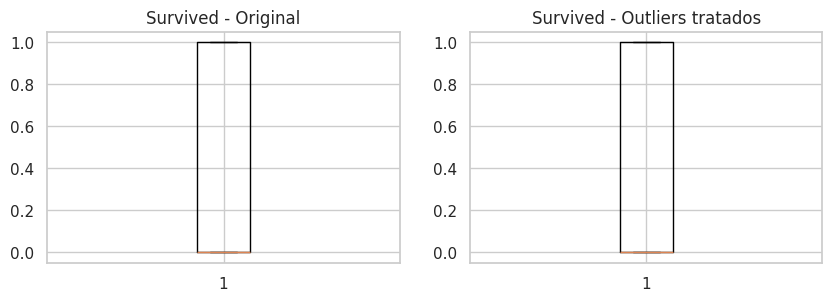

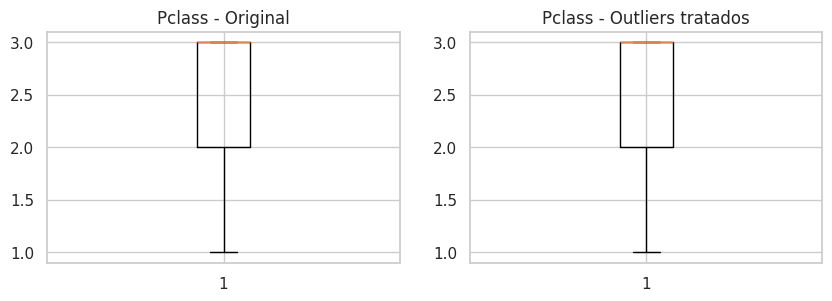

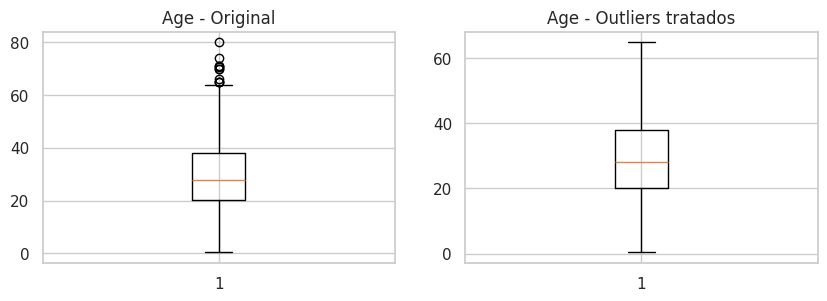

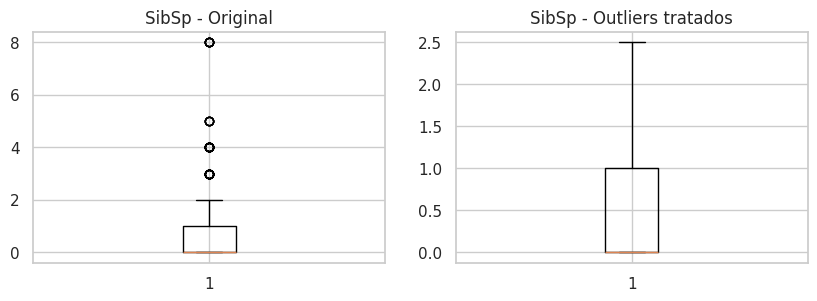

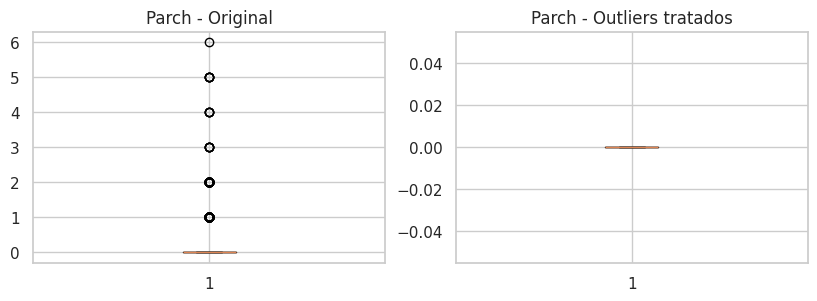

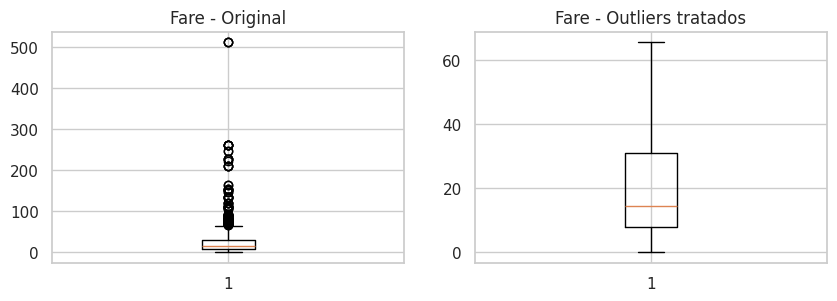

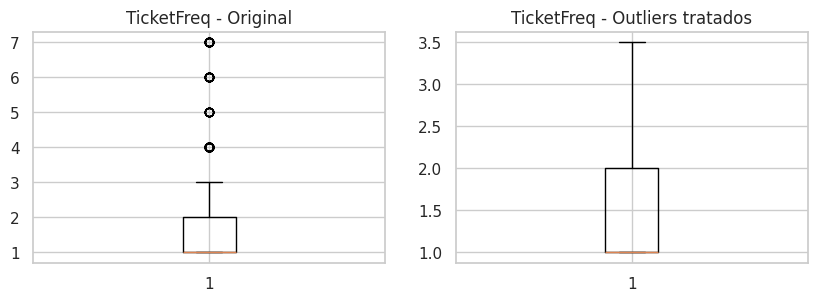

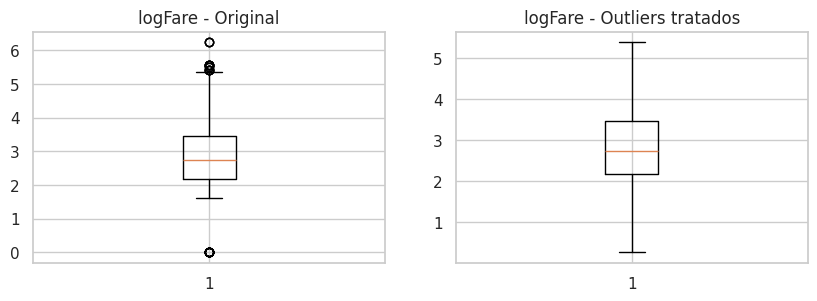

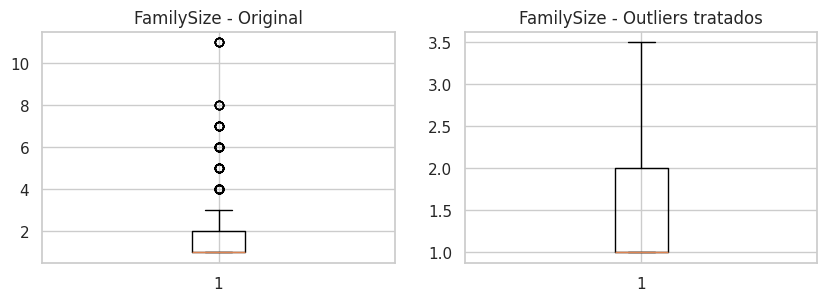

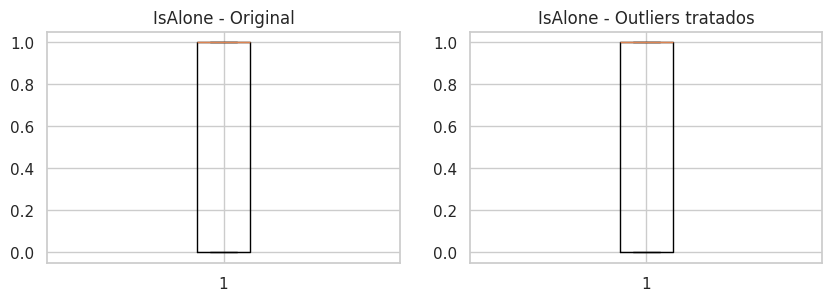

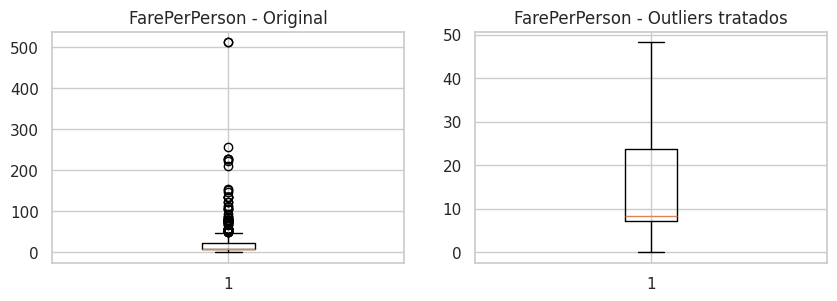

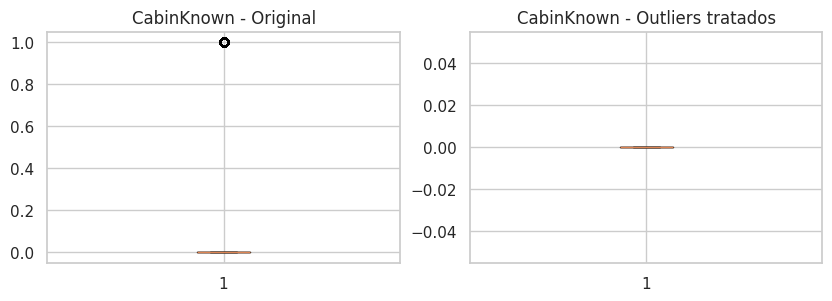

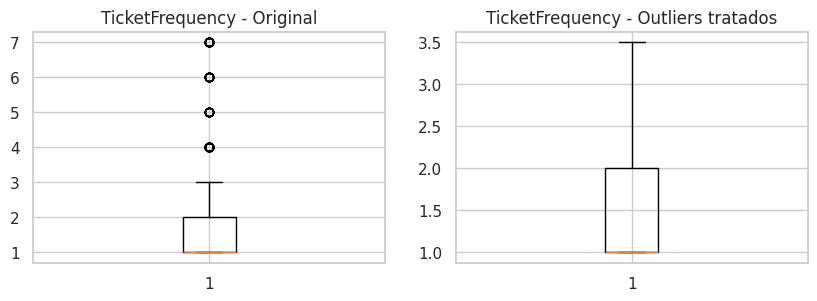

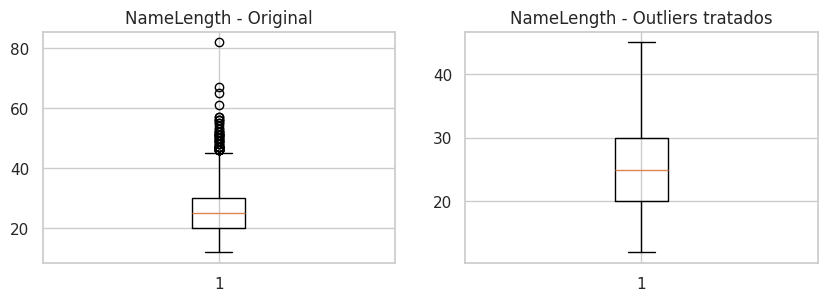

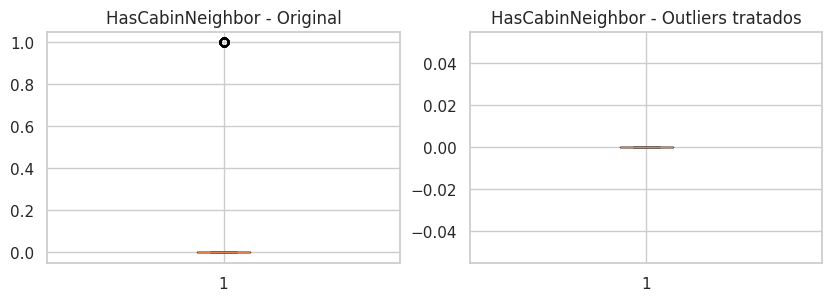

In [ ]:

# 1. Seleccionar columnas numéricas continuas (float64 o int64) excluyendo ID
num_cols = df_final.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols = [c for c in num_cols if c != 'PassengerId']  # opcional: excluir ID

# 2. Copiar DataFrame
df_final_outliers = df_final.copy()

# 3. Detección y winsorización con IQR
outlier_summary = {}

for col in num_cols:
    Q1 = df_final_outliers[col].quantile(0.25)
    Q3 = df_final_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    # Contar outliers
    n_outliers = ((df_final_outliers[col] < lower) | (df_final_outliers[col] > upper)).sum()
    outlier_summary[col] = {
        "Q1": Q1, "Q3": Q3, "IQR": IQR, "Lower": lower, "Upper": upper,
        "Outliers detectados": n_outliers
    }

    # Winsorización
    df_final_outliers[col] = np.where(df_final_outliers[col] < lower, lower,
                                      np.where(df_final_outliers[col] > upper, upper, df_final_outliers[col]))

# 4. Resumen de outliers
outlier_summary_df = pd.DataFrame(outlier_summary).T
print(outlier_summary_df)

# 5. Boxplots antes y después (opcional)
for col in num_cols:
    plt.figure(figsize=(10,3))
    plt.subplot(1,2,1)
    plt.boxplot(df_final[col].dropna())
    plt.title(f'{col} - Original')
    plt.subplot(1,2,2)
    plt.boxplot(df_final_outliers[col].dropna())
    plt.title(f'{col} - Outliers tratados')
    plt.show()

In [ ]:
# ESCALAR
# 1. Seleccionar variables continuas (float64) excluyendo ID y binarias
continuous_cols = df_final_outliers.select_dtypes(include=['float64']).columns.tolist()
continuous_cols = [c for c in continuous_cols if c not in ['PassengerId']]

# 2. Escalador (elegimos StandardScaler)
scaler = StandardScaler()

# 3. Aplicar escalado
df_scaled = df_final_outliers.copy()
df_scaled[continuous_cols] = scaler.fit_transform(df_scaled[continuous_cols])

# 4. Revisar estadísticas antes y después
print("Antes del escalado:")
print(df_final_outliers[continuous_cols].describe().T[['mean','std','min','max']])
print("\nDespués del escalado:")
print(df_scaled[continuous_cols].describe().T[['mean','std','min','max']])


Antes del escalado:
                       mean        std        min        max
Survived           0.383838   0.486592   0.000000   1.000000
Pclass             2.308642   0.836071   1.000000   3.000000
Age               29.622700  14.316665   0.420000  64.812500
SibSp              0.426487   0.708246   0.000000   2.500000
Parch              0.000000   0.000000   0.000000   0.000000
Fare              24.046813  20.481625   0.000000  65.634400
TicketFreq         1.613356   0.877977   1.000000   3.500000
logFare            2.962066   0.942199   0.269441   5.383513
FamilySize         1.664983   0.914151   1.000000   3.500000
IsAlone            0.602694   0.489615   0.000000   1.000000
FarePerPerson     15.496058  13.494798   0.000000  48.291667
CabinKnown         0.000000   0.000000   0.000000   0.000000
TicketFrequency    1.613356   0.877977   1.000000   3.500000
NameLength        26.578002   8.198337  12.000000  45.000000
HasCabinNeighbor   0.000000   0.000000   0.000000   0.000000

Des

## 2.2 Análisis de Interacciones

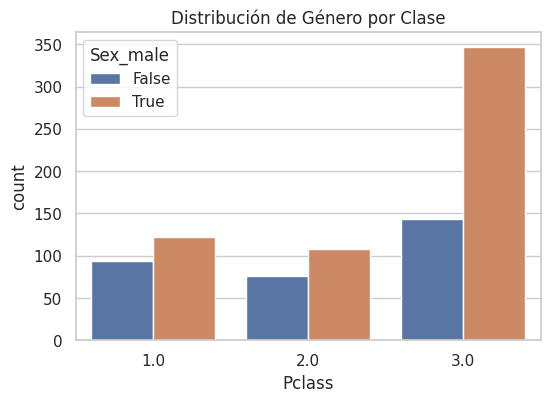

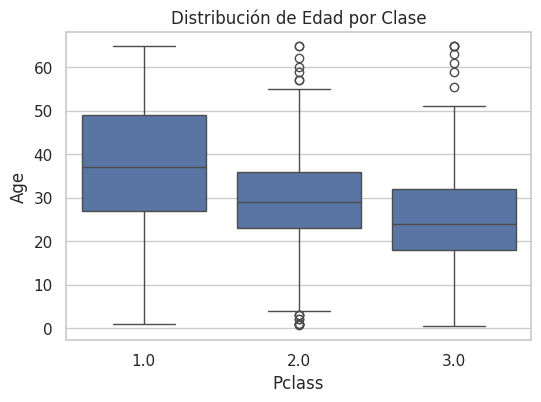

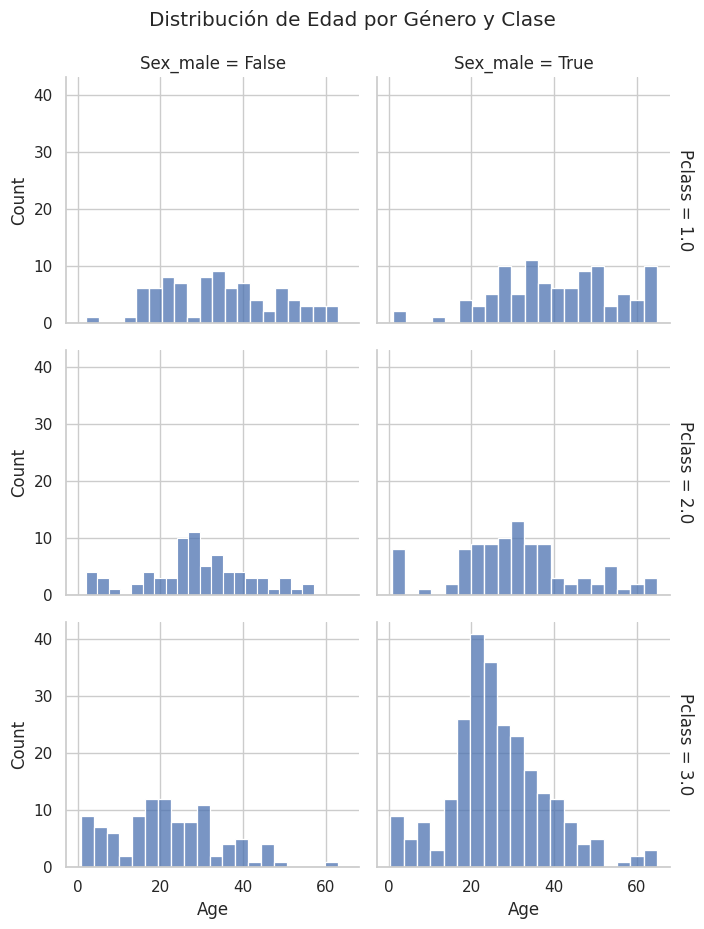

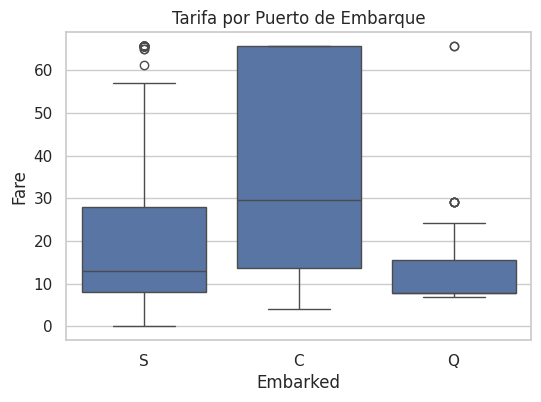

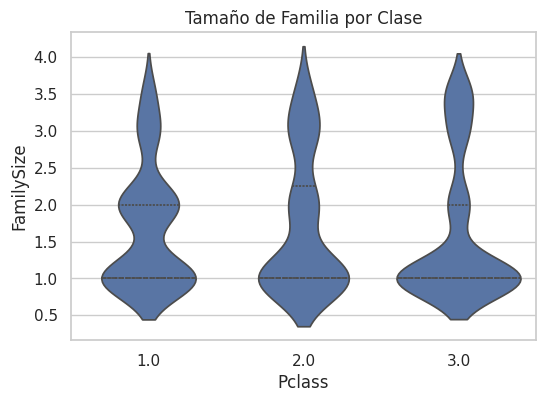

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# 1️⃣ Género × Clase → Conteo por clase
plt.figure(figsize=(6,4))
sns.countplot(data=df_final_outliers, x="Pclass", hue="Sex_male")
plt.title("Distribución de Género por Clase")
plt.show()

# 2️⃣ Edad × Clase → Boxplot
plt.figure(figsize=(6,4))
sns.boxplot(data=df_final_outliers, x="Pclass", y="Age")
plt.title("Distribución de Edad por Clase")
plt.show()

# 3️⃣ Género × Edad × Clase → FacetGrid (para ver 'mujeres y niños primero')
g = sns.FacetGrid(df_final_outliers, row="Pclass", col="Sex_male", margin_titles=True, height=3, aspect=1.2)
g.map(sns.histplot, "Age", bins=20, kde=False)
g.fig.suptitle("Distribución de Edad por Género y Clase", y=1.03)
plt.show()

# 4️⃣ Tarifa × Puerto de embarque → Boxplot
plt.figure(figsize=(6,4))
sns.boxplot(data=df_final_outliers, x="Embarked", y="Fare")
plt.title("Tarifa por Puerto de Embarque")
plt.show()

# 5️⃣ Tamaño de familia × Clase → Violinplot
plt.figure(figsize=(6,4))
sns.violinplot(data=df_final_outliers, x="Pclass", y="FamilySize", inner="quartile")
plt.title("Tamaño de Familia por Clase")
plt.show()


# 3. TRATAMIENTO DE VALORES FALTANTES

##3.1Análisis Detallado de Missingness



In [ ]:
df.info()
print(df['Embarked'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   PassengerId       891 non-null    int64   
 1   Survived          891 non-null    int64   
 2   Pclass            891 non-null    int64   
 3   Name              891 non-null    object  
 4   Sex               891 non-null    object  
 5   Age               714 non-null    float64 
 6   SibSp             891 non-null    int64   
 7   Parch             891 non-null    int64   
 8   Ticket            891 non-null    object  
 9   Fare              891 non-null    float64 
 10  Cabin             204 non-null    object  
 11  Embarked          889 non-null    object  
 12  AgeGroup          714 non-null    category
 13  TicketFreq        891 non-null    int64   
 14  logFare           891 non-null    float64 
 15  FareCat           891 non-null    object  
 16  FareCat_alt       891 non-

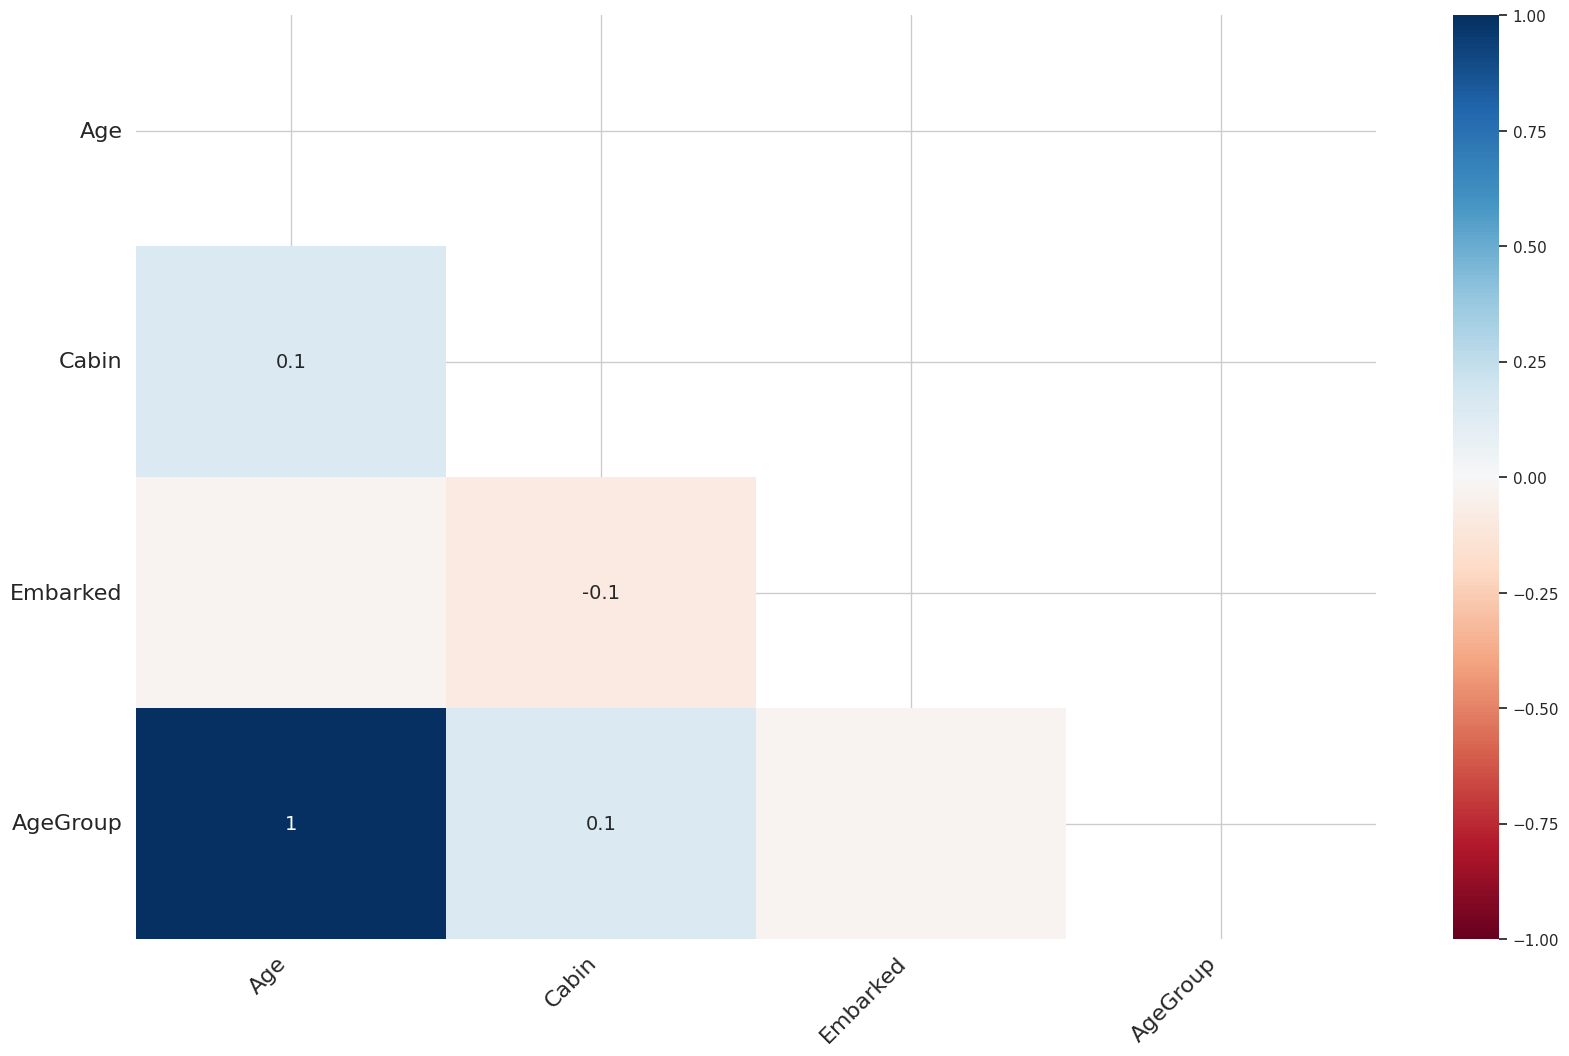

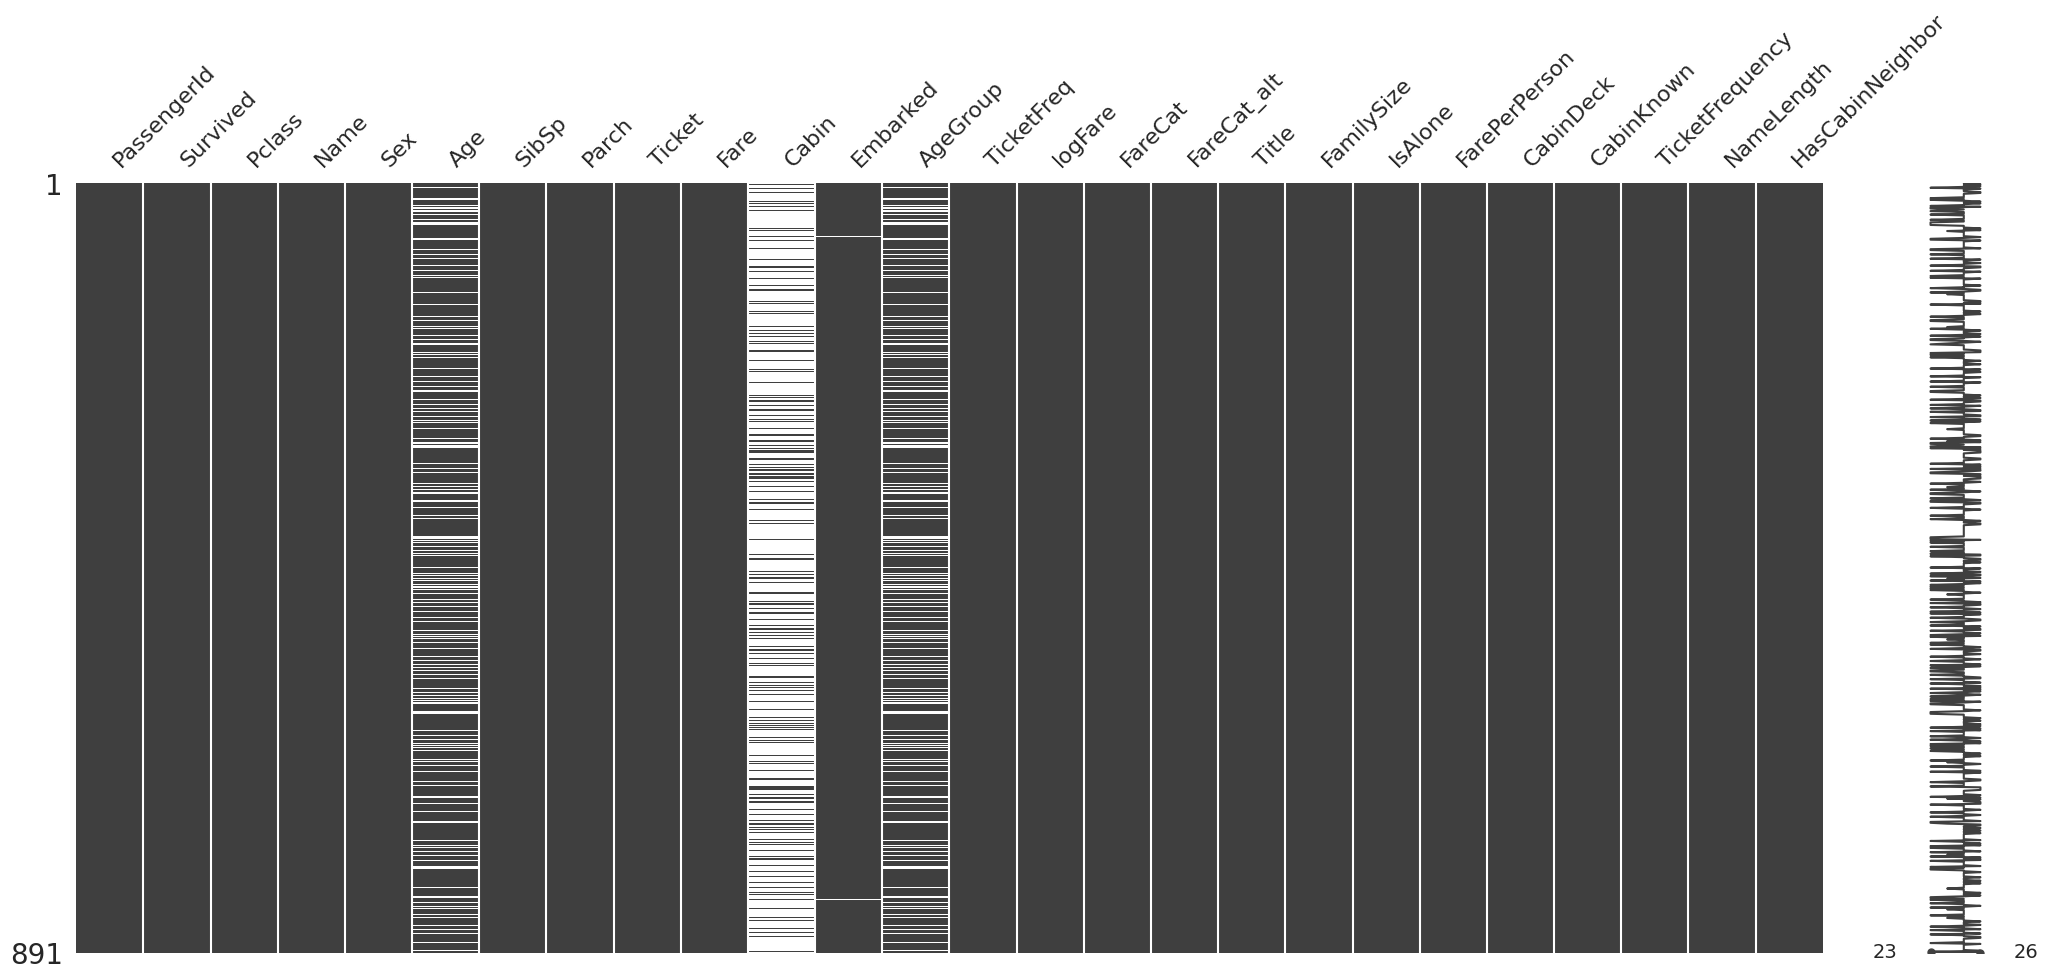

     Age    AgeGroup
0   22.0  YoungAdult
1   38.0       Adult
2   26.0  YoungAdult
3   35.0  YoungAdult
4   35.0  YoungAdult
5    NaN         NaN
6   54.0       Adult
7    2.0       Child
8   27.0  YoungAdult
9   14.0        Teen
10   4.0       Child
11  58.0       Adult
12  20.0  YoungAdult
13  39.0       Adult
14  14.0        Teen
15  55.0       Adult
16   2.0       Child
17   NaN         NaN
18  31.0  YoungAdult
19   NaN         NaN
Chi²: 2115.2238, df: 2655, p-value: 1.0000


In [ ]:
############################
# 1 - Patrón de missingness:
############################

import missingno as msno
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy.linalg import inv
from scipy.stats import chi2

# Mapa de calor de correlación entre faltantes
msno.heatmap(df)
plt.show()

# Matriz visual
msno.matrix(df)
plt.show()

# Demostración de las columnas Age y AgeGroup (alta correlación)
cols_to_show = ['Age', 'AgeGroup']
print(df[cols_to_show].head(20))

# Ejecutar Little's MCAR test
def little_mcar_test(df):
    # Filtramos columnas numéricas
    data = df.select_dtypes(include=[np.number])

    # Calculamos medias por columna (para imputación)
    means = data.mean()

    # Calculamos matriz de covarianzas
    cov_matrix = np.cov(data.fillna(means).T)
    inv_cov_matrix = inv(cov_matrix)

    chi_square = 0
    df_total = 0

    for i in range(data.shape[0]):
        row = data.iloc[i]
        mask = row.notna()
        if mask.sum() < data.shape[1]:  # si hay al menos un NaN
            diff = (row.fillna(means) - means)[mask]
            cov_sub = inv_cov_matrix[np.ix_(mask, mask)]
            chi_square += diff @ cov_sub @ diff.T
            df_total += mask.sum()

    p_value = 1 - chi2.cdf(chi_square, df_total)
    return chi_square, df_total, p_value

# Ejecución del test
chi2_stat, dof, p_val = little_mcar_test(df)
print(f"Chi²: {chi2_stat:.4f}, df: {dof}, p-value: {p_val:.4f}")


Tanto en el heatmap como en la matrix, podemos ver que no hay realción significativa entre las columnas con datos faltantes. AgeGroup y Age tienen correlación de 1, ya que a partir del Age se crea el AgeGroup. Si hay un NaN en Age, será NaN en AgeGroup.

p-value > 0.05 → No rechazamos la hipótesis nula de MCAR.

Interpretación: Los valores faltantes del dataset parecen ocurrir completamente al azar (MCAR). No dependen de otras variables ni del valor faltante.

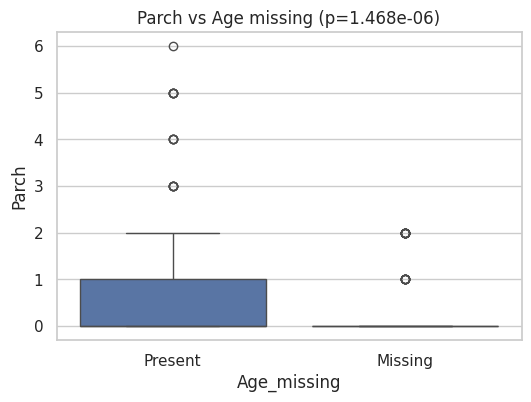

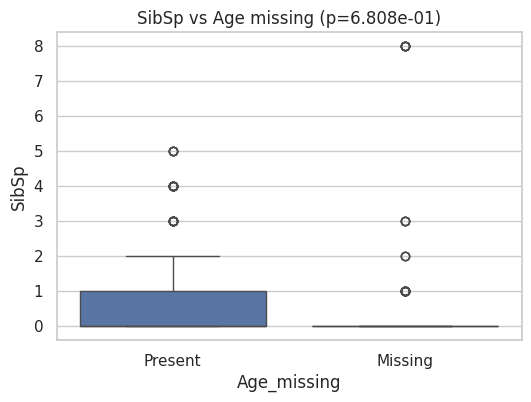

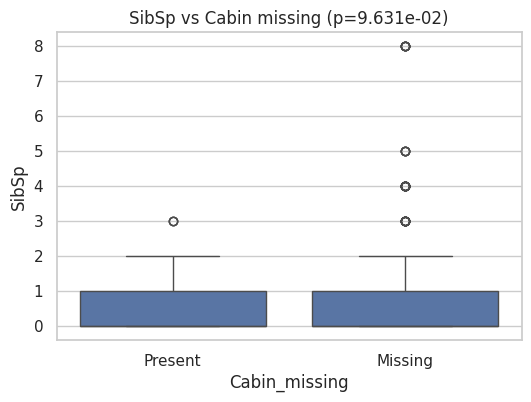

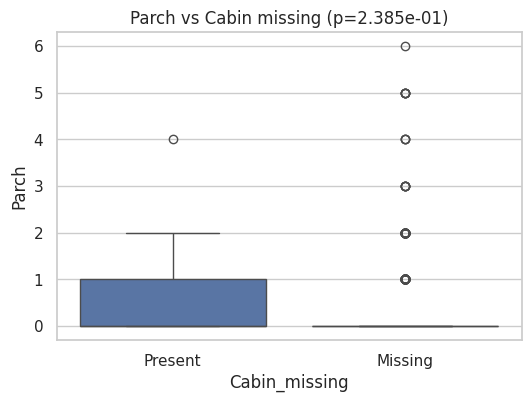


Top 5 relaciones para Age:
Parch: p-value=1.468e-06
SibSp: p-value=6.808e-01

Top 5 relaciones para Cabin:
SibSp: p-value=9.631e-02
Parch: p-value=2.385e-01


In [ ]:
#################################################
# 2. Análisis de casos completos vs. incompletos:
#################################################

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Columnas con missing
missing_cols = ['Age', 'Cabin']

# Columnas numéricas completas (rellena esto con tus columnas completas)
complete_cols = ['SibSp', 'Parch']  # <--- pon aquí tus columnas numéricas completas

# Diccionario para guardar resultados
top5_relations = {}

for col in missing_cols:
    # Crear indicador de missing
    df[f'{col}_missing'] = df[col].isna().astype(int)

    results = []
    for num_col in complete_cols:
        # Evitar comparar con la misma columna
        if num_col == col:
            continue

        # t-test
        group_missing = df.loc[df[f'{col}_missing']==1, num_col].dropna()
        group_present = df.loc[df[f'{col}_missing']==0, num_col].dropna()

        if len(group_missing) > 0 and len(group_present) > 0:
            t_stat, p_val = ttest_ind(group_missing, group_present, equal_var=False)
            results.append((num_col, p_val))

    # Ordenar por p-value (menor p-value = mayor diferencia)
    results.sort(key=lambda x: x[1])
    top5 = results[:5]
    top5_relations[col] = top5

    # Graficar
    for num_col, p_val in top5:
        plt.figure(figsize=(6,4))
        sns.boxplot(x=f'{col}_missing', y=num_col, data=df)
        plt.xticks([0,1], ['Present', 'Missing'])
        plt.title(f'{num_col} vs {col} missing (p={p_val:.3e})')
        plt.show()

# Mostrar resultados top5
for col, top5 in top5_relations.items():
    print(f"\nTop 5 relaciones para {col}:")
    for num_col, p_val in top5:
        print(f"{num_col}: p-value={p_val:.3e}")




El análisis de los casos completos e incompletos mostró que los valores faltantes de Age no se distribuyen al azar. Al comparar la distribución de Parch entre pasajeros con Age presente y ausente mediante boxplots, se observa que quienes no registraron su edad tienden a tener Parch = 0, mientras que los pasajeros con familiares a bordo (Parch ≥ 1) tienen Age registrada. Esta visualización permite ver claramente cómo varían las distribuciones según la presencia de datos.


El test de diferencias significativas (t-test) confirma esta observación, con un p-value muy bajo que indica que la diferencia en Parch entre filas con Age faltante y filas completas es estadísticamente significativa. Esto tiene implicaciones para el sesgo: eliminar o imputar Age sin considerar la relación con Parch podría sesgar los resultados, ya que los missing están asociados a un patrón familiar y no ocurren de manera aleatoria.

          missing_Age  missing_Cabin  missing_Embarked
Survived    -0.092197      -0.316912          0.060095
Pclass       0.172933       0.725541         -0.074282
Age               NaN      -0.249732          0.074120
SibSp        0.018958       0.040460         -0.022508
Parch       -0.124104      -0.036987         -0.022467
Fare        -0.100707      -0.482075          0.045646


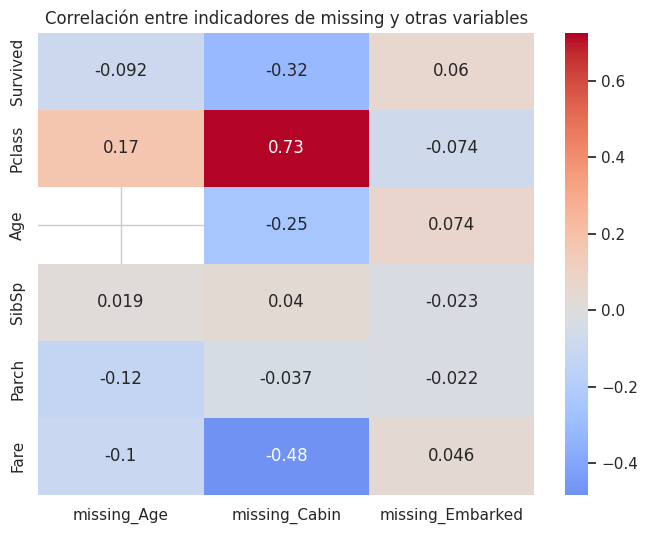

In [ ]:
##################################
# Correlación con otras variables:
##################################

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Crear indicadores de missing
cols_with_na = ['Age', 'Cabin', 'Embarked']
for col in cols_with_na:
    df[f'missing_{col}'] = df[col].isna().astype(int)

# Seleccionar variables numéricas originales
numeric_cols = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

# Crear matriz de correlaciones
corr_results = pd.DataFrame(index=numeric_cols)

for col in cols_with_na:
    missing_col = f'missing_{col}'
    corr = df[numeric_cols].corrwith(df[missing_col])
    corr_results[missing_col] = corr

# Mostrar correlaciones ordenadas
print(corr_results)

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_results, annot=True, cmap='coolwarm', center=0)
plt.title('Correlación entre indicadores de missing y otras variables')
plt.show()


**Conclusión:**

La mayor correlación fue (0.72) indica que a mayor Pclass (es decir, peor clase), más probabilidad de que Cabin esté vacío.

Es decir, pasajeros de tercera clase casi nunca tienen dato de Cabin. Pasajeros de primera clase casi siempre tienen Cabin registrado.

##3.2 Estrategias de Imputación

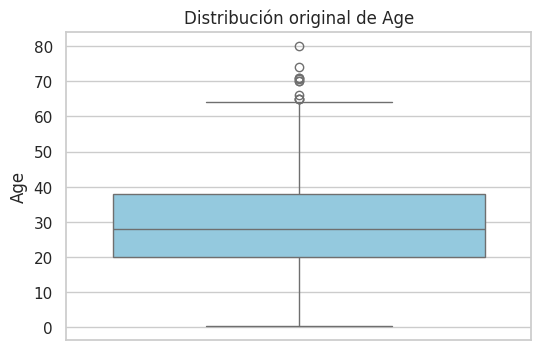

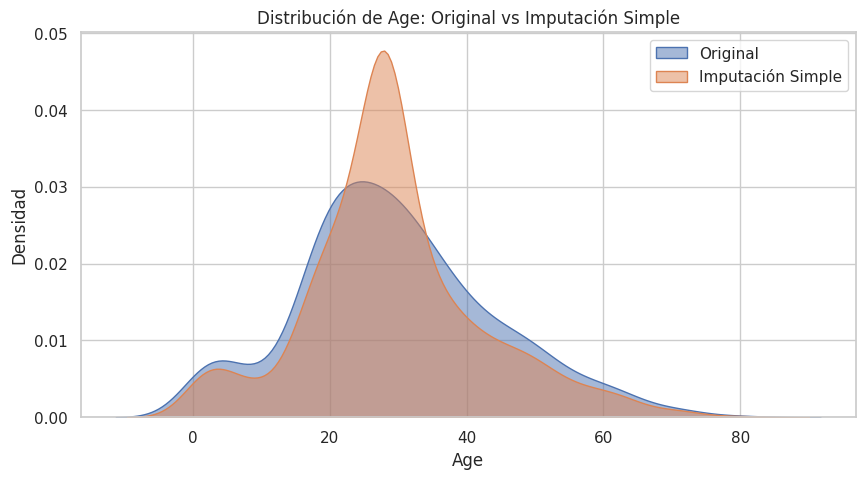

Nulos en Age antes: 177
Nulos en Age después: 0

Tabla comparativa de Media y Mediana:
             Versión      Media  Mediana
0           Original  29.699118     28.0
1  Imputación Simple  29.361582     28.0


In [ ]:
##########################
# Método Simple (baseline)
##########################

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

plt.figure(figsize=(6,4))
sns.boxplot(y=df['Age'], color='skyblue')
plt.title('Distribución original de Age')
plt.ylabel('Age')
plt.show()

# Crear copia del DataFrame
df_simple = df.copy()

# Imputación simple: mediana
num_imputer = SimpleImputer(strategy='median')
df_simple['Age'] = num_imputer.fit_transform(df_simple[['Age']])

# Visualización: comparar Original vs Imputado
plt.figure(figsize=(10, 5))
sns.kdeplot(df['Age'], label='Original', fill=True, alpha=0.5)
sns.kdeplot(df_simple['Age'], label='Imputación Simple', fill=True, alpha=0.5)
plt.title('Distribución de Age: Original vs Imputación Simple')
plt.xlabel('Age')
plt.ylabel('Densidad')
plt.legend()
plt.show()

print("Nulos en Age antes:", df['Age'].isna().sum())
print("Nulos en Age después:", df_simple['Age'].isna().sum())

# Crear tabla con estadísticas antes y después
stats = pd.DataFrame({
    'Versión': ['Original', 'Imputación Simple'],
    'Media': [df['Age'].mean(skipna=True), df_simple['Age'].mean()],
    'Mediana': [df['Age'].median(skipna=True), df_simple['Age'].median()]
})

print("\nTabla comparativa de Media y Mediana:")
print(stats)

La mayoría de los pasajeros son jóvenes o adultos jóvenes. Esto indica que la mediana del grupo será representativa para la mayoría de los datos, por lo que imputar usando la mediana tiene sentido.


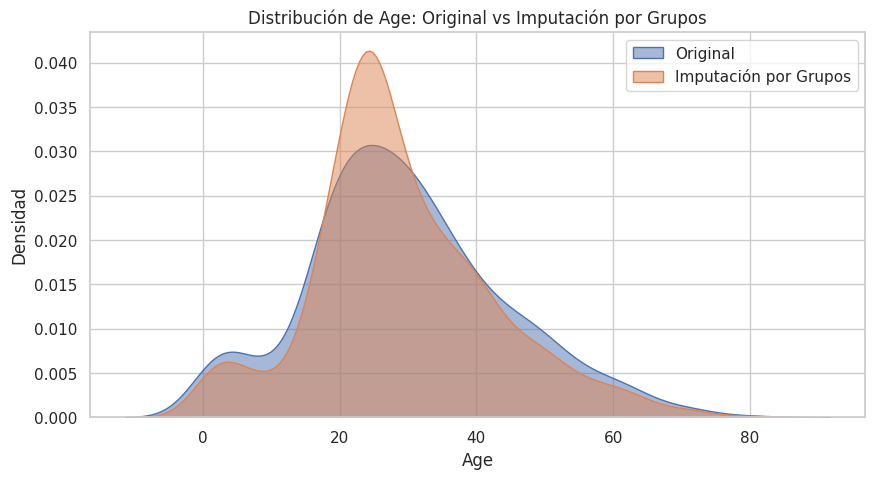

Nulos en Age antes: 177
Nulos en Age después: 0

Tabla comparativa de Media y Mediana:
                 Versión      Media  Mediana
0               Original  29.699118     28.0
1  Imputación por Grupos  29.112424     26.0


In [ ]:
#########################
# Método Basado en Grupos
#########################

# Crear copia del DataFrame
df_groups = df.copy()

# Crear columna Title a partir de Name
df_groups['Title'] = df_groups['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Imputación por grupos: medianas por Title y Pclass
df_groups['Age'] = df_groups.groupby(['Sex', 'Pclass'])['Age'].transform(
    lambda x: x.fillna(x.median())
)

# Visualización: Original vs Imputado por Grupos
plt.figure(figsize=(10, 5))
sns.kdeplot(df['Age'], label='Original', fill=True, alpha=0.5)
sns.kdeplot(df_groups['Age'], label='Imputación por Grupos', fill=True, alpha=0.5)
plt.title('Distribución de Age: Original vs Imputación por Grupos')
plt.xlabel('Age')
plt.ylabel('Densidad')
plt.legend()
plt.show()

print("Nulos en Age antes:", df['Age'].isna().sum())
print("Nulos en Age después:", df_groups['Age'].isna().sum())

# Tabla con estadísticas antes y después
stats_groups = pd.DataFrame({
    'Versión': ['Original', 'Imputación por Grupos'],
    'Media': [df['Age'].mean(skipna=True), df_groups['Age'].mean()],
    'Mediana': [df['Age'].median(skipna=True), df_groups['Age'].median()]
})

print("\nTabla comparativa de Media y Mediana:")
print(stats_groups)

Usar Sex y Pclass tiene sentido porque, aunque la correlación sea baja, son variables que conceptualmente influyen en la edad (por ejemplo, pasajeros de primera clase suelen ser mayores, niños viajaban con familia en tercera clase, etc.).

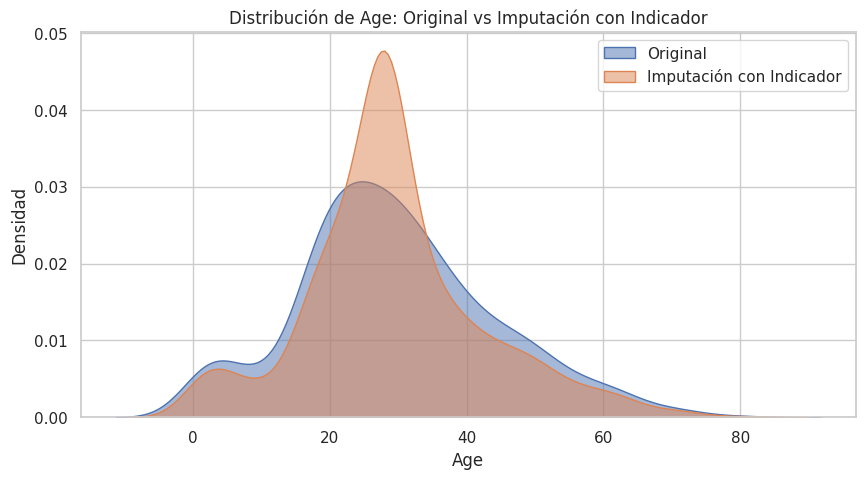

Nulos en Age antes: 177
Nulos en Age después: 0

Tabla comparativa de Media y Mediana:
                    Versión      Media  Mediana
0                  Original  29.699118     28.0
1  Imputación con Indicador  29.361582     28.0


In [ ]:
#####################
# Método de Indicador
#####################

from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt

# Crear copia para este método
df_indicator = df.copy()

# Crear columna binaria indicando missingness
df_indicator['Age_missing'] = df_indicator['Age'].isna().astype(int)

# Imputación simple (mediana) para Age
num_imputer = SimpleImputer(strategy='median')
df_indicator['Age'] = num_imputer.fit_transform(df_indicator[['Age']])

# Visualización: Original vs Imputación con Indicador
plt.figure(figsize=(10, 5))
sns.kdeplot(df['Age'], label='Original', fill=True, alpha=0.5)
sns.kdeplot(df_indicator['Age'], label='Imputación con Indicador', fill=True, alpha=0.5)
plt.title('Distribución de Age: Original vs Imputación con Indicador')
plt.xlabel('Age')
plt.ylabel('Densidad')
plt.legend()
plt.show()

print("Nulos en Age antes:", df['Age'].isna().sum())
print("Nulos en Age después:", df_indicator['Age'].isna().sum())

# Tabla con estadísticas antes y después
stats_indicator = pd.DataFrame({
    'Versión': ['Original', 'Imputación con Indicador'],
    'Media': [df['Age'].mean(skipna=True), df_indicator['Age'].mean()],
    'Mediana': [df['Age'].median(skipna=True), df_indicator['Age'].median()]
})

print("\nTabla comparativa de Media y Mediana:")
print(stats_indicator)